#### Description: Scrape NeurIPs conference papers
##### Created: 19/04/24
##### Modified: 19/06/25

In [101]:
import glob
import feather
import os, sys
import numpy as np
import pandas as pd
import multiprocessing
from pyprind import ProgBar
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

sys.path.append('../')
from utils.pdf_parser import PDFParser
from utils.section_processor import SectionProcessor

sys.path.append('../../')
from libs.multiprocess import Multiprocessor

['1988.feather',
 '1989.feather',
 '1990.feather',
 '1991.feather',
 '1992.feather',
 '1993.feather',
 '1994.feather',
 '1995.feather',
 '1996.feather',
 '1997.feather',
 '1998.feather',
 '1999.feather',
 '2000.feather',
 '2001.feather',
 '2002.feather',
 '2003.feather',
 '2004.feather',
 '2005.feather',
 '2006.feather',
 '2007.feather',
 '2008.feather',
 '2009.feather',
 '2010.feather',
 '2011.feather',
 '2012.feather',
 '2013.feather',
 '2014.feather',
 '2015.feather',
 '2016.feather',
 '2017.feather',
 '2018.feather']

In [110]:
path = '/mnt/netapp/nlp/nips/processed/'
# years = np.arange(1989, 2004)
years = os.listdir(path)
print('{:7} {:7} {:7} {:1}'.format('Year', 'Good', 'Bad', 'Percent Failed'))
for y in sorted(years):
    df = feather.read_dataframe(path + '/' + y)
    
    word_counts = df.abstracts.apply(lambda x: len(x.split(' ')))
    good_abstracts = df[(word_counts.values < 400) & (word_counts.values > 20)]
    bad_abstracts = df[(word_counts.values > 400) | (word_counts.values < 20)]
    
    print('{:7} {:3} {:6} {:7} {:2.1f}'.format(str(y.split('.')[0]), len(good_abstracts), len(df) - len(good_abstracts), '', (len(df) - len(good_abstracts))/len(df)*100 ))

Year    Good    Bad     Percent Failed
1988     67     27         28.7
1989     91     10         9.9
1990    117      5         4.1
1991    137      7         4.9
1992    118      9         7.1
1993    134     24         15.2
1994    134      6         4.3
1995    140     12         7.9
1996    147      5         3.3
1997    136     14         9.3
1998    135     16         10.6
1999    139     11         7.3
2000    134     18         11.8
2001    178     19         9.6
2002    197     10         4.8
2003    191      7         3.5
2004    195     12         5.8
2005    189     18         8.7
2006    189     15         7.4
2007    207     10         4.6
2008    234     16         6.4
2009    246     16         6.1
2010    279     13         4.5
2011    297      9         2.9
2012    356     12         3.3
2013    355      5         1.4
2014    390     21         5.1
2015    385     18         4.5
2016    538     31         5.4
2017    644     35         5.2
2018    945     64         

In [3]:
from threading import Timer

class TooLong(Exception):
    def __init__(self, m):
        self.message = m
    def __str__(self):
        return self.message 
    
class Watchdog:
    def __init__(self, timeout, user_exception):  # timeout in seconds
        self.exception = user_exception
        self.timeout = timeout
        self.handler = self.defaultHandler
        self.timer = Timer(self.timeout, self.handler)
        self.timer.start()

    def reset(self):
        self.timer.cancel()
        self.timer = Timer(self.timeout, self.handler)
        self.timer.start()

    def stop(self):
        self.timer.cancel()

    def defaultHandler(self):
        raise self.exception

In [4]:
# Setup an Exception to be triggered by the watchdog
tl = TooLong('Too Long')

def abstract_extractor(path):    
    try:
        dog = Watchdog(45, tl) # set the watchdog to trigger the too long exception after 45 seconds
        try:
            pdf = PDFParser(path)
            pdf.convert_pdf_to_txt()
            pdf.convert_text_to_ascii()

            pdf.get_abstract()
        except:
            return 'failed'
    except TooLong as ex:
        #print(ex)
        return 'failed'
    dog.stop() # stop the watchdog
        
    return pdf.clean_text(pdf.abstract)

In [9]:
for y in ['2000']:
    print(y)
    raw_path = '/mnt/netapp/nlp/nips/raw/' + y
    files = os.listdir(raw_path)
    files = [os.path.join(raw_path, f) for f in files]
    
    with multiprocessing.Pool(70) as p:
        abstracts = p.map(abstract_extractor, files)
    
    print('Finished Extracting')
    df = pd.DataFrame({'abstracts' : abstracts})
    
    print('Writting to output: ', '/mnt/netapp/nlp/nips/processed/' + str(y) + '.feather')
    df.to_feather('/mnt/netapp/nlp/nips/processed/' + str(y) + '.feather')

2000
Finished Extracting
Writting to output:  /mnt/netapp/nlp/nips/processed/2000.feather


In [35]:
raw_path = '/mnt/netapp/nlp/nips/raw/' + y
files = os.listdir(raw_path)
files = [os.path.join(raw_path, f) for f in files]

path = files[0]

pdf = PDFParser(path)
pdf.convert_pdf_to_txt()
pdf.convert_text_to_ascii()

pdf.get_abstract()

print(len(pdf.abstract))

0


In [44]:
abstract_estimated_start = pdf.ascii_text.lower().find('abstract')
#         abstract_estimated_end = text.find('\nIntroduction')

#         # If there is no newline character, try to find the abstract without it
#         if abstract_estimated_end < abstract_estimated_start:
#             abstract_estimated_end = text.lower().find('introduction')

#         # If teh value for the intro is super high, its not actually the intro
#         # Just a mention of the word 'introduction'
#         # Instead use the numeric section heading to try and find the intro
#         if 2000 < len(text[abstract_estimated_start:abstract_estimated_end].split()):
#             abstract_estimated_end = text.lower().find('\n1 ')            


type_1 = pdf.ascii_text.find('\nIntroduction')
type_2 = pdf.ascii_text.lower().find('introduction')
type_3 = pdf.ascii_text.lower().find('\n1 ')

all_types = np.array([type_1, type_2, type_3])
abstract_estimated_end = np.min(all_types[all_types > 0])
print(abstract_estimated_start, abstract_estimated_end)

251 2503


In [42]:
print(pdf.ascii_text)

394 

STORING COVARIANCE BY THE ASSOCIATIVE 
LONGTERM POTENTIATION AND DEPRESSION 
OF SYNAPTIC STRENGTHS IN THE HIPPOCAMPUS 

Patric K.  Stanton  and Terrence J.  Sejnowskit 

Department of Biophysics 
Johns Hopkins University 

Baltimore, MD 21218 

ABSTRACT 

In modeling studies or memory  based on  neural networks, both the selective 
enhancement and depression or synaptic strengths are required ror effident storage 
or  inrormation  (Sejnowski,  1977a,b;  Kohonen,  1984;  Bienenstock  et  aI,  1982; 
Sejnowski and Tesauro, 1989).  We have tested this assumption in the hippocampus, 
a  cortical  structure  or the  brain  that  is  involved  in  long-term  memory.  A  brier, 
high-frequency  activation  or excitatory  synapses  in  the hippocampus  produces  an 
increase  in  synaptic strength  known  as  long-term  potentiation,  or  L TP (BUss  and 
Lomo,  1973),  that can  last  ror  many  days.  LTP is  known  to  be  Hebbian since  it 
requires the simultaneous release  or neuro

In [37]:
print(pdf.abstract)

In [81]:
y = '2015'
df = feather.read_dataframe('/mnt/netapp/nlp/nips/processed/' + str(y) + '.feather')

(array([ 50., 296.,  51.,   4.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([  1. ,  97.9, 194.8, 291.7, 388.6, 485.5, 582.4, 679.3, 776.2,
        873.1, 970. ]),
 <a list of 10 Patch objects>)

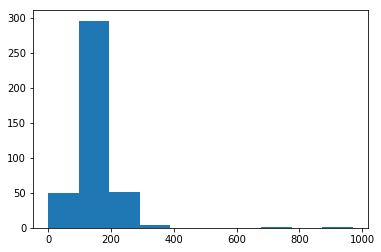

In [93]:
word_counts = df.abstracts.apply(lambda x: len(x.split(' ')))
good_abstracts = df[(word_counts.values < 400) & (word_counts.values > 20)]
bad_abstracts = df[(word_counts.values > 400) | (word_counts.values < 20)]

plt.hist(word_counts)

In [96]:
good_word_counts = good_abstracts.abstracts.apply(lambda x: len(x.split(' ')))

(array([ 16.,  50., 100.,  88.,  72.,  29.,  17.,   8.,   2.,   3.]),
 array([ 58. ,  84.9, 111.8, 138.7, 165.6, 192.5, 219.4, 246.3, 273.2,
        300.1, 327. ]),
 <a list of 10 Patch objects>)

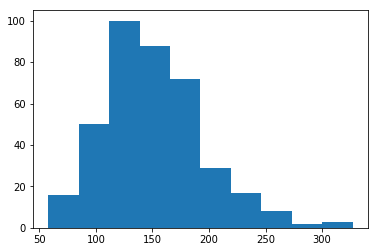

In [97]:
plt.hist(good_word_counts)